
# 4.4. Call Python User Defined Functions From MATLAB


In this chapter, we will leverage a demo developed by a Finance colleague. In this example, he is responsible for building enterprise web predictive analytics that other business critical applications can connect to as a web service. It follows the same structure as the weather example in [<u>chapter 2</u>](about:blank<#_End-to-end_project_with%3E).


This web service is [**forecasting the price of cryptocurrencies**](https://www.mathworks.com/videos/integrating-python-with-matlab-1605793241650.html)**:**


<u>forecast.matlab.com/crypto.js?coin=ETH</u>


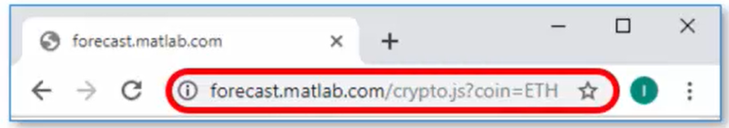


It returns data in the following form (JSON):


`[{``"Time"``:``"2022-01-21T12:00:00Z"``,``"predictedPrice"``:``2466.17``},`


`...`


`{``"Time"``:``"2022-01-21T17:00:00Z"``,``"predictedPrice"``:``2442.25``}]`


The first step is to develop an application that simply shows the historical price movement of a particular cryptocurrency:


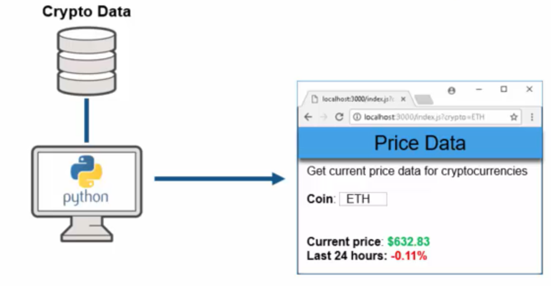


This allows you to monitor the evolution of the price over the last 24 hours and take decisions to buy or sell your crypto assets based on this. Then one day, you manager comes to you and says:


*“Hey, I have an idea. If we had access to the predicted forward-looking data as opposed to the historical data, we could make additional profit beyond what we're currently making, even if the prediction is 100% accurate.“*


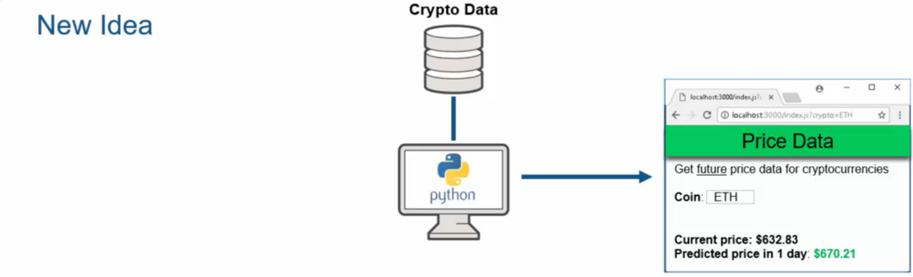


Let’s assume the organization has a few quants that have extensive MATLAB expertise. And they know exactly how to build out such predictive models that the business users are looking for.


However, before we can get to that, our first challenge is to call the Python data scraping libraries and pull that data directly into MATLAB. Our first task at hand: Parse the cryptocurrency URL that we are connecting to, and just get out the domain name. For that, we want to use this function that's contained within the Python standard libraries and use it from within MATLAB. In this case, we are going to call a package [`urllib`](https://docs.python.org/3/library/urllib.html). It contains a sub-module called `parse`, that contains in turn the function `urlparse`.


In [1]:
startDate = '2022-01-21T12:00:00Z';
stopDate = '2022-01-21T17:00:00Z';
url = "https://api.pro.coinbase.com/products/ETH-USD/candles?start="+startDate+"&end="+stopDate+"&granularity=60"

In [2]:
urlparts = py.urllib.parse.urlparse(url)

In [3]:
domain = urlparts.netloc


To avoid the unnecessary back and forth of intermediate data between MATLAB and Python, we write a [Python User Defined Module](https://www.mathworks.com/help/matlab/matlab_external/call-user-defined-custom-module.html), called `dataLib.py` with a few functions in it:

<pre>
jsonData = py.dataLib.getPriceData("ETH", startDate, stopDate)
data = py.dataLib.parseJson(jsonData, [0,4])
</pre>

`dataLib.py` imports 1-minute bars from [Coinbase Pro](https://pro.coinbase.com/).  Note, the API does not fetch the first minute specified by the start date so the times span (start, stop]. To return data we are using a variety of data structures from Numpy arrays to lists and dictionaries, and even JSON.


This is how you would call this function from MATLAB.


Note: dataLib.py must be on Python's path


In [4]:
product = "ETH"

In [5]:
startDate = '2022-01-21T12:00:00Z';
stopDate = '2022-01-21T17:00:00Z';
jsonData = py.dataLib.getPriceData(product, startDate, stopDate);


If you want to add interactivity to your Live Script, you can add so called [Live Controls](https://www.mathworks.com/help/matlab/matlab_prog/add-interactive-controls-to-a-live-script.html). This is helpful to point other people to areas where you may want to change parameters or select things to do scenario analysis.


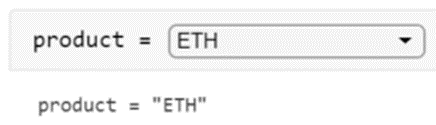


You can insert controls from the ribbon:


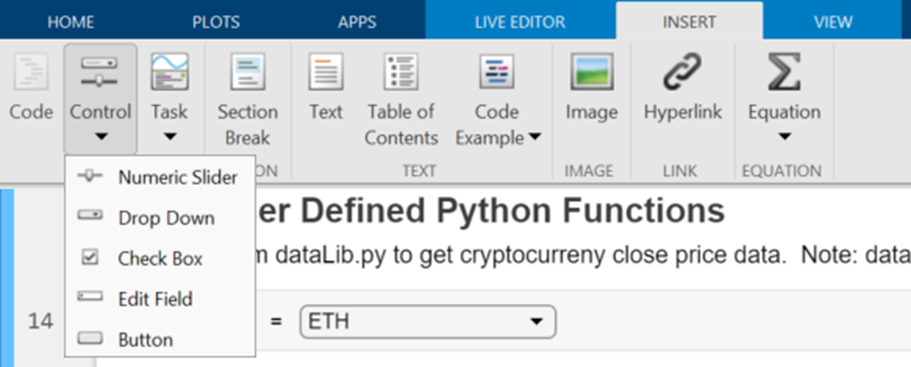


This is how you would parametrize the Live Control:


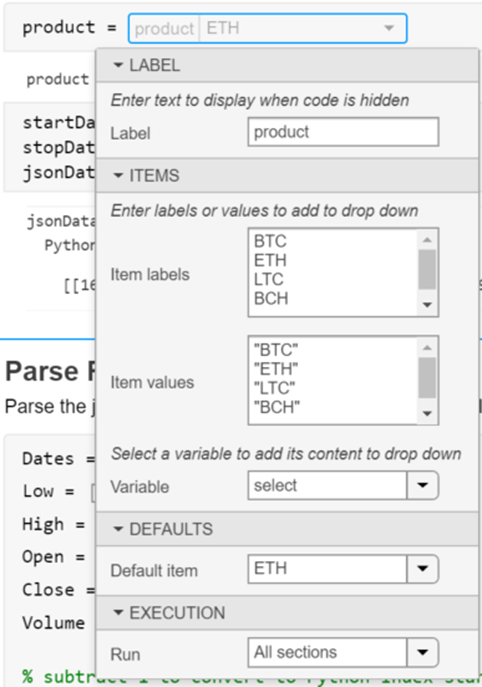


Another type of Live Control that is useful here are simple checkboxes to select the information we want to return from the `parseJson` function:


In [6]:
Dates = true;
Low = false;
High = false;
Open = false;
Close = true;
Volume = false;
% subtract 1 to convert to Python index starting at 0
selectedColumns = find([Dates Low High Open Close Volume])-1



Pay attention to the fact that we are subtracting 1 to the resulting array to adapt to Python indexing starting at 0.


In [7]:
% this function returns back two outputs as a tuple
data = py.dataLib.parseJson(jsonData, selectedColumns);


The last thing we will do in this part of the story is to convert the Python function outputs do MATLAB Data types (this will be covered in the last section of this chapter on <u>mapping data between Python and MATLAB</u>).


In [8]:
priceData = data{1}

In [9]:
columnNames = data{2}


Then we can cast over the Numpy array on the right-hand side by just using the double command:


In [10]:
priceData = double(priceData)


Likewise, we have a variety of commands for casting lists like string (or cell before R2022a):


In [11]:
columnNames = string(columnNames);


Once we have those data in MATLAB, we will convert it over to the MATLAB table, which is basically equivalent to Pandas data frames:


In [12]:
data = array2table(priceData, 'VariableNames', columnNames);


Like tables, timetable are built-in data constructs that appeared in MATLAB over the last couple of years to make our lives easy for doing simple types of tasks or even complex types of tasks. If I want to deal with time zones and convert the times – which are with respect to universal time zone – to a view of someone who is in New York, the command [datetime](https://www.mathworks.com/help/matlab/ref/datetime.html#d123e298898) allows us to do that conversion:


In [13]:
data.Date = datetime(data.Date, 'ConvertFrom', 'posixtime', 'TimeZone', 'America/New_York')

In [14]:
plot(data.Date, data.Close)


[**Reload Modified User-Defined Python Module**](https://www.mathworks.com/help/matlab/matlab_external/call-user-defined-custom-module.html#buuz303)


What if you’ve made modifications to the functions inside of your `dataLib` module? You call those again from MATLAB, but you don’t see any difference. It is because you need to reload the module:


In [15]:
mod = py.importlib.import_module('dataLib');
py.importlib.reload(mod);


You may need to unload the module first, by clearing the classes. This will delete all variables, scripts and classes in your MATLAB workspace.


In [16]:
clear classes


If you're running Python out-of-process, another approach is to simply [terminate the process](https://www.mathworks.com/help/matlab/matlab_external/reload-python-interpreter.html).


In [17]:
terminate(pyenv)